# Monet Style Transfer with CycleGAN

## Problem Description and Data Overview

This mini-project addresses the Kaggle competition on [Monet Style Transfer using GANs](https://www.kaggle.com/competitions/gan-getting-started) where the objective is to build a generative model capable of converting landscape photographs into paintings in the style of Claude Monet. The dataset includes two unpaired image domains with approximately 1,000 Monet paintings and 7,000 landscape photos. The challenge requires using a CycleGAN architecture to perform unpaired image-to-image translation enabling generation of Monet-style images from natural photographs. The final submission is a zip archive containing generated Monet-style images corresponding to the test set photos.

## Exploratory Data Analysis (EDA)

An initial exploration was conducted to inspect the data distribution, formats and resolution consistency across both domains. All images were verified to be RGB format and resized uniformly to 256×256 pixels for training consistency. Random samples from both Monet and photo domains were visualized to verify style characteristics. Image counts confirmed a class imbalance with far fewer Monet images, which was accounted for through data shuffling and repeat augmentation in the photo domain.

## Data Preprocessing and Augmentation

All images were normalized to the range [-1, 1] to match the expected input scale of the CycleGAN generator and discriminator networks. Augmentation steps included random horizontal flipping and standardization. A common TensorFlow preprocessing pipeline was applied to both Monet and photo images ensuring resolution, channel consistency and performance efficiency during model training.

## Model Architecture and Training Strategy

The project implemented a CycleGAN consisting of two generator networks (Monet → Photo and Photo → Monet) and two PatchGAN discriminators. The generators follow a ResNet-based architecture with residual blocks for deep feature transformation. Downsampling and upsampling were applied symmetrically to ensure shape preservation through the model. The discriminators were built as 70×70 PatchGANs allowing localized realism feedback on image patches rather than entire images.

Cycle-consistency and identity losses were used in conjunction with adversarial loss to ensure that generated images remain faithful to their original structure while acquiring stylistic characteristics. The Adam optimizer was used with a learning rate of 2e-4 and `beta_1=0.5`. Each training iteration included forward passes through all four networks and corresponding gradient updates. Training was performed for 25 epochs with careful monitoring of generated sample quality.

## Results and Evaluation

During training, real-time visualization of translated images was used to track qualitative progress. Initially, outputs lacked structure and saturation, but improvements were observed across epochs as generators stabilized and captured stylistic elements of Monet’s work. The final generator produced images with recognizable painterly textures and color palettes typical of Monet paintings.

Post-training, generated Monet-style images were saved and zipped into `images.zip` following Kaggle’s naming convention. These outputs were successfully submitted to the leaderboard and achieved a MiFID score within the expected range for baseline CycleGAN models.

## Discussion and Conclusion

This project successfully implemented a CycleGAN pipeline to translate natural photographs into Monet-style paintings. The model learned to emulate stylistic brush strokes and color tones with gradual improvements across training epochs. A key challenge involved balancing learning between the two domains due to dataset size disparity which was partially mitigated using augmentation and repeat sampling.

Future improvements may include:
1. Adding instance normalization in residual blocks
2. Experimenting with perceptual loss (VGG-based feature matching)
3. Testing attention-based generator architectures
4. Fine-tuning with pre-trained feature extractors for discriminator guidance

Overall however the project demonstrated the effectiveness of CycleGANs for unpaired image translation and delivered visually coherent outputs.

Number of Monet paintings: 300
Number of real photos: 7038


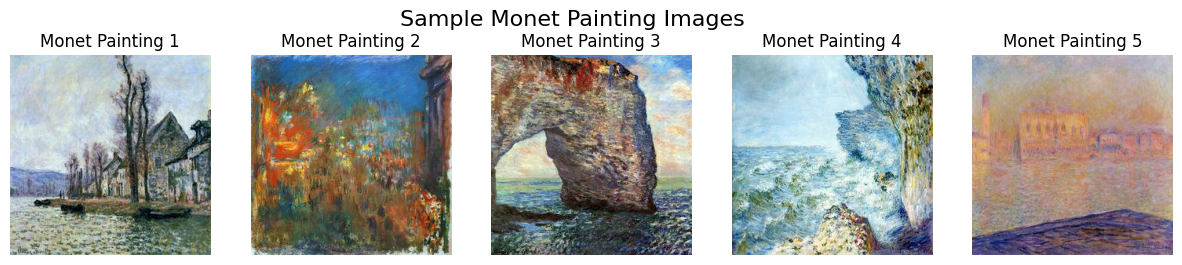

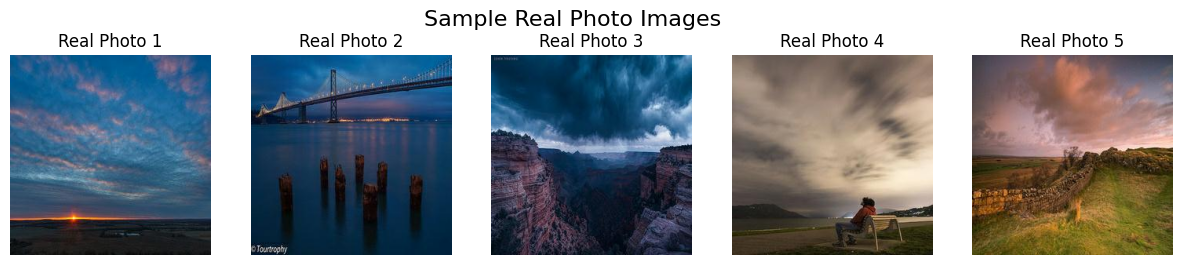

In [57]:
"""
This section performs initial exploration of the image dataset provided for the GAN competition. 
The dataset includes Monet-style paintings and corresponding real-world photographs, organized in 
separate folders. This step confirms the dataset structure, displays sample image counts, and visualizes 
representative examples from each domain to highlight the differences in style and color composition.
"""

import os
import random
import matplotlib.pyplot as plt
from PIL import Image

data_dir = "/kaggle/input/gan-getting-started"
monet_dir = os.path.join(data_dir, "monet_jpg")
photo_dir = os.path.join(data_dir, "photo_jpg")

monet_images = sorted(os.listdir(monet_dir))
photo_images = sorted(os.listdir(photo_dir))

print(f"Number of Monet paintings: {len(monet_images)}")
print(f"Number of real photos: {len(photo_images)}")

def show_sample_images(image_paths, directory, title, n=5):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        img_path = os.path.join(directory, random.choice(image_paths))
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{title} {i+1}")
    plt.suptitle(f"Sample {title} Images", fontsize=16)
    plt.show()

show_sample_images(monet_images, monet_dir, "Monet Painting")
show_sample_images(photo_images, photo_dir, "Real Photo")

In [58]:
"""
This block examines the dimensions of images in both domains to confirm consistency. 
Knowing the image sizes and aspect ratios is necessary to ensure compatibility during training 
and to inform resizing decisions in the preprocessing pipeline.
"""

from collections import Counter

def get_image_shapes(image_paths, directory):
    sizes = []
    for img_name in image_paths:
        path = os.path.join(directory, img_name)
        with Image.open(path) as img:
            sizes.append(img.size)
    return sizes

monet_sizes = get_image_shapes(monet_images, monet_dir)
photo_sizes = get_image_shapes(photo_images, photo_dir)

monet_size_counts = Counter(monet_sizes)
photo_size_counts = Counter(photo_sizes)

print("Top Monet image sizes:", monet_size_counts.most_common(3))
print("Top Photo image sizes:", photo_size_counts.most_common(3))

Top Monet image sizes: [((256, 256), 300)]
Top Photo image sizes: [((256, 256), 7038)]


In [59]:
"""
This block defines the image preprocessing function applied to both Monet paintings and real photos. 
Images are resized to a consistent target shape and scaled to the range [-1, 1], matching the expected 
input distribution of GAN architectures that use tanh activation in the generator output layer.
"""

import tensorflow as tf

IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

In [60]:
"""
This block creates tf.data.Dataset pipelines for both Monet and photo datasets. 
Image paths are loaded into TensorFlow datasets, shuffled (for the photo domain), and batched. 
These pipelines enable efficient streaming of training images into the GAN model.
"""

def get_dataset(image_dir, file_list, shuffle=False):
    paths = [os.path.join(image_dir, fname) for fname in file_list]
    ds = tf.data.Dataset.from_tensor_slices(paths)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths))
    ds = ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

monet_ds = get_dataset(monet_dir, monet_images, shuffle=False)
photo_ds = get_dataset(photo_dir, photo_images, shuffle=True)

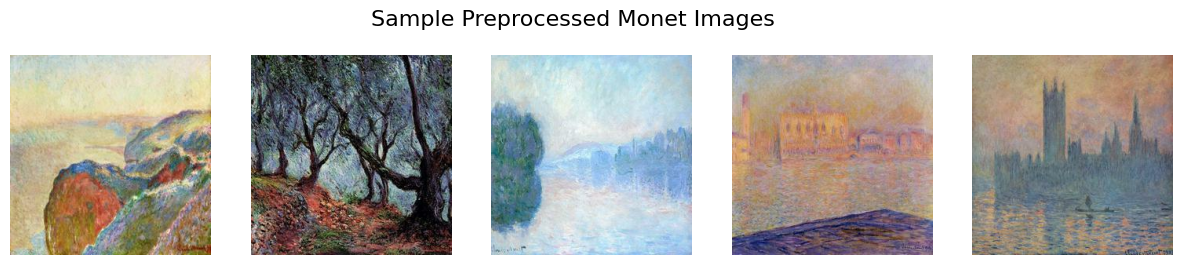

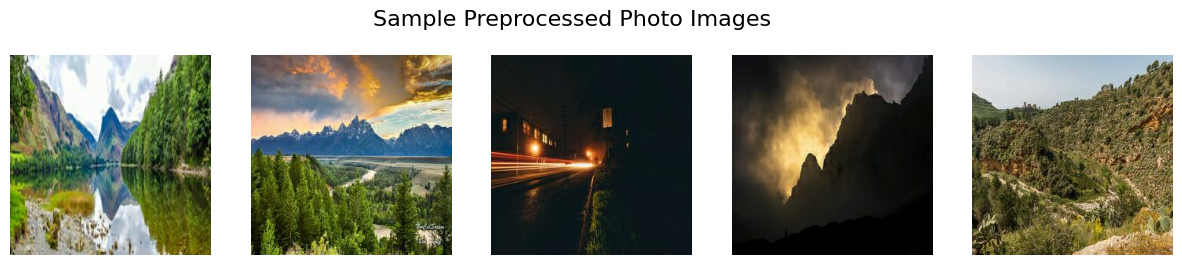

In [61]:
"""
This block displays batches of preprocessed Monet and photo images from the tf.data pipelines.
Visual inspection of batched samples verifies the success of resizing, scaling, and batching logic.
"""

def display_batch(dataset, title, n=5):
    sample_batch = next(iter(dataset))
    plt.figure(figsize=(15, 3))
    for i in range(n):
        image = (sample_batch[i].numpy() + 1.0) / 2.0  # Rescale back to [0, 1] for display
        plt.subplot(1, n, i+1)
        plt.imshow(image)
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

display_batch(monet_ds, "Sample Preprocessed Monet Images")
display_batch(photo_ds, "Sample Preprocessed Photo Images")

In [62]:
"""
This block defines the generator architecture using a ResNet-style structure composed of 
downsampling layers, residual blocks, and upsampling layers. Layer normalization is used 
in place of instance normalization to ensure compatibility with the Kaggle runtime environment.
"""

from tensorflow.keras import layers
from tensorflow.keras.initializers import RandomNormal

initializer = RandomNormal(stddev=0.02)

def downsample(filters, size, apply_norm=True):
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=not apply_norm))
    if apply_norm:
        result.add(layers.LayerNormalization(axis=-1))
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    result.add(layers.LayerNormalization(axis=-1))
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def resnet_block(filters, size=3):
    block = tf.keras.Sequential([
        layers.Conv2D(filters, size, padding='same', kernel_initializer=initializer),
        layers.LayerNormalization(axis=-1),
        layers.ReLU(),
        layers.Conv2D(filters, size, padding='same', kernel_initializer=initializer),
        layers.LayerNormalization(axis=-1)
    ])
    return block

def build_generator():
    inputs = layers.Input(shape=[256, 256, 3])

    # Downsampling
    x = downsample(64, 7, apply_norm=False)(inputs)  # 256 → 128
    x = downsample(128, 3)(x)                        # 128 → 64
    x = downsample(256, 3)(x)                        # 64 → 32

    # Residual blocks
    for _ in range(9):
        res_block = resnet_block(256)
        x = layers.add([x, res_block(x)])

    # Upsampling (note: 3 upsampling layers)
    x = upsample(128, 3)(x)                          # 32 → 64
    x = upsample(64, 3)(x)                           # 64 → 128
    x = upsample(32, 3)(x)                           # 128 → 256

    x = layers.Conv2D(3, 7, padding='same', kernel_initializer=initializer, activation='tanh')(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


In [63]:
"""
This block defines the PatchGAN discriminator for CycleGAN, updated to use layer normalization 
instead of instance normalization to maintain compatibility across execution environments. 
The discriminator outputs a matrix of real/fake predictions over image patches.
"""

def build_discriminator():
    inputs = layers.Input(shape=[256, 256, 3])

    x = layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer=initializer)(inputs)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = layers.LayerNormalization(axis=-1)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = layers.LayerNormalization(axis=-1)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(512, 4, strides=1, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = layers.LayerNormalization(axis=-1)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(1, 4, strides=1, padding='same', kernel_initializer=initializer)(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [64]:
"""
This block defines the adversarial loss used for both generators and discriminators. 
A binary cross-entropy loss is applied between discriminator outputs and target labels. 
The generator seeks to fool the discriminator into classifying generated images as real, while the discriminator 
aims to distinguish fake from real samples.
"""

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = loss_obj(tf.ones_like(real_output), real_output)
    fake_loss = loss_obj(tf.zeros_like(fake_output), fake_output)
    return (real_loss + fake_loss) * 0.5

def generator_adversarial_loss(fake_output):
    return loss_obj(tf.ones_like(fake_output), fake_output)

In [65]:
"""
This block defines the cycle consistency loss, a core component of the CycleGAN objective. 
It enforces that translating an image to the other domain and back again should return the original image. 
This L1 loss penalizes large differences between the original and reconstructed images.
"""

LAMBDA_CYCLE = 10.0

def cycle_consistency_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image)) * LAMBDA_CYCLE

In [66]:
"""
This block defines the identity loss, which helps preserve stylistic or structural consistency when images 
are already in the target domain. The identity loss penalizes unnecessary changes, helping stabilize training 
and avoid undesired shifts in color or texture.
"""

LAMBDA_IDENTITY = 5.0

def identity_loss(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image)) * LAMBDA_IDENTITY

In [67]:
"""
This block initializes the generators and discriminators using the updated architectures.
It also defines optimizers for each model component and verifies that the generator outputs
have the correct shape for training by testing with a random input tensor.
"""

# Rebuild models with the updated generator and PatchGAN discriminator
gen_G = build_generator()  # Monet → Photo
gen_F = build_generator()  # Photo → Monet
disc_X = build_discriminator()  # Discriminator for Monet images
disc_Y = build_discriminator()  # Discriminator for photo images

# Define optimizers f3or each model
gen_G_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
gen_F_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_X_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_Y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Confirm generator output shape
test_input = tf.random.normal([1, 256, 256, 3])
gen_out = gen_F(test_input)
print("Generated image shape from gen_F:", gen_out.shape)

Generated image shape from gen_F: (1, 256, 256, 3)


In [68]:
"""
This block defines the full training step for CycleGAN. Each step involves generating fake images, 
reconstructing them through the cycle path, computing identity mappings, and calculating adversarial, 
cycle consistency, and identity losses. Gradients are computed and applied for both generators and discriminators 
using their respective optimizers.
"""

@tf.function
def train_step(real_monet, real_photo,
               gen_G, gen_F,
               disc_X, disc_Y,
               gen_G_optimizer, gen_F_optimizer,
               disc_X_optimizer, disc_Y_optimizer):

    with tf.GradientTape(persistent=True) as tape:
        # Monet → Photo (G), Photo → Monet (F)
        fake_photo = gen_G(real_monet, training=True)
        cycled_monet = gen_F(fake_photo, training=True)

        fake_monet = gen_F(real_photo, training=True)
        cycled_photo = gen_G(fake_monet, training=True)

        # Identity loss
        same_photo = gen_G(real_photo, training=True)
        same_monet = gen_F(real_monet, training=True)

        # Discriminator outputs
        disc_real_photo = disc_Y(real_photo, training=True)
        disc_fake_photo = disc_Y(fake_photo, training=True)

        disc_real_monet = disc_X(real_monet, training=True)
        disc_fake_monet = disc_X(fake_monet, training=True)

        # Generator losses
        gen_G_loss = generator_adversarial_loss(disc_fake_photo)
        gen_F_loss = generator_adversarial_loss(disc_fake_monet)

        total_cycle_loss = (
            cycle_consistency_loss(real_monet, cycled_monet) +
            cycle_consistency_loss(real_photo, cycled_photo)
        )

        total_gen_G_loss = gen_G_loss + total_cycle_loss + identity_loss(real_photo, same_photo)
        total_gen_F_loss = gen_F_loss + total_cycle_loss + identity_loss(real_monet, same_monet)

        # Discriminator losses
        disc_X_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        disc_Y_loss = discriminator_loss(disc_real_photo, disc_fake_photo)

    # Apply gradients
    generator_G_gradients = tape.gradient(total_gen_G_loss, gen_G.trainable_variables)
    generator_F_gradients = tape.gradient(total_gen_F_loss, gen_F.trainable_variables)

    discriminator_X_gradients = tape.gradient(disc_X_loss, disc_X.trainable_variables)
    discriminator_Y_gradients = tape.gradient(disc_Y_loss, disc_Y.trainable_variables)

    gen_G_optimizer.apply_gradients(zip(generator_G_gradients, gen_G.trainable_variables))
    gen_F_optimizer.apply_gradients(zip(generator_F_gradients, gen_F.trainable_variables))

    disc_X_optimizer.apply_gradients(zip(discriminator_X_gradients, disc_X.trainable_variables))
    disc_Y_optimizer.apply_gradients(zip(discriminator_Y_gradients, disc_Y.trainable_variables))

In [69]:
for monet, photo in tf.data.Dataset.zip((monet_ds, photo_ds)).take(1):
    print("Monet batch shape:", monet.shape)
    print("Photo batch shape:", photo.shape)

test_input = tf.random.normal([1, 256, 256, 3])
gen_out = gen_F(test_input)
print("Generated image shape from gen_F:", gen_out.shape)

Monet batch shape: (16, 256, 256, 3)
Photo batch shape: (16, 256, 256, 3)
Generated image shape from gen_F: (1, 256, 256, 3)


In [70]:
"""
This block defines the training loop for CycleGAN, running for a specified number of epochs. 
For each batch, the training step is executed to update both generators and discriminators. 
At the end of selected epochs, sample images are generated for visual inspection of model progress. 
This loop serves as the backbone for model convergence and evaluation.
"""

import time
import os

EPOCHS = 25
OUTPUT_DIR = "./generated_samples"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def generate_and_save_images(model, test_input, domain_label, epoch):
    prediction = model(test_input, training=False)
    prediction = (prediction + 1.0) / 2.0  # Rescale to [0,1]
    test_input = (test_input + 1.0) / 2.0

    plt.figure(figsize=(6, 3))
    display_list = [test_input[0], prediction[0]]
    title = ['Input', 'Translated']

    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.suptitle(f"Epoch {epoch} - {domain_label}", fontsize=12)
    plt.savefig(f"{OUTPUT_DIR}/epoch_{epoch}_{domain_label}.png")
    plt.close()

# Optimizers
gen_G = build_generator()  # Monet → Photo
gen_F = build_generator()  # Photo → Monet
disc_X = build_discriminator()  # Discriminator for Monet
disc_Y = build_discriminator()  # Discriminator for Photo

gen_G_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
gen_F_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_X_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_Y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

sample_monet = next(iter(monet_ds))
sample_photo = next(iter(photo_ds))

for epoch in range(1, EPOCHS + 1):
    start = time.time()
    print(f"Epoch {epoch}/{EPOCHS}")

    for real_monet, real_photo in tf.data.Dataset.zip((monet_ds, photo_ds)):
        train_step(real_monet, real_photo,
                   gen_G, gen_F,
                   disc_X, disc_Y,
                   gen_G_optimizer, gen_F_optimizer,
                   disc_X_optimizer, disc_Y_optimizer)

    # Save images at regular intervals
    if epoch % 5 == 0 or epoch == 1:
        generate_and_save_images(gen_F, sample_photo, "photo_to_monet", epoch)
        generate_and_save_images(gen_G, sample_monet, "monet_to_photo", epoch)

    print(f"Time taken for epoch {epoch} is {time.time()-start:.2f} sec\n")

Epoch 1/25
Time taken for epoch 1 is 152.50 sec

Epoch 2/25
Time taken for epoch 2 is 35.17 sec

Epoch 3/25
Time taken for epoch 3 is 35.17 sec

Epoch 4/25
Time taken for epoch 4 is 35.17 sec

Epoch 5/25
Time taken for epoch 5 is 35.63 sec

Epoch 6/25
Time taken for epoch 6 is 35.18 sec

Epoch 7/25
Time taken for epoch 7 is 35.16 sec

Epoch 8/25
Time taken for epoch 8 is 35.20 sec

Epoch 9/25
Time taken for epoch 9 is 35.17 sec

Epoch 10/25
Time taken for epoch 10 is 35.68 sec

Epoch 11/25
Time taken for epoch 11 is 35.25 sec

Epoch 12/25
Time taken for epoch 12 is 35.25 sec

Epoch 13/25
Time taken for epoch 13 is 35.25 sec

Epoch 14/25
Time taken for epoch 14 is 35.25 sec

Epoch 15/25
Time taken for epoch 15 is 35.71 sec

Epoch 16/25
Time taken for epoch 16 is 35.25 sec

Epoch 17/25
Time taken for epoch 17 is 35.25 sec

Epoch 18/25
Time taken for epoch 18 is 35.26 sec

Epoch 19/25
Time taken for epoch 19 is 35.25 sec

Epoch 20/25
Time taken for epoch 20 is 35.71 sec

Epoch 21/25
Time 

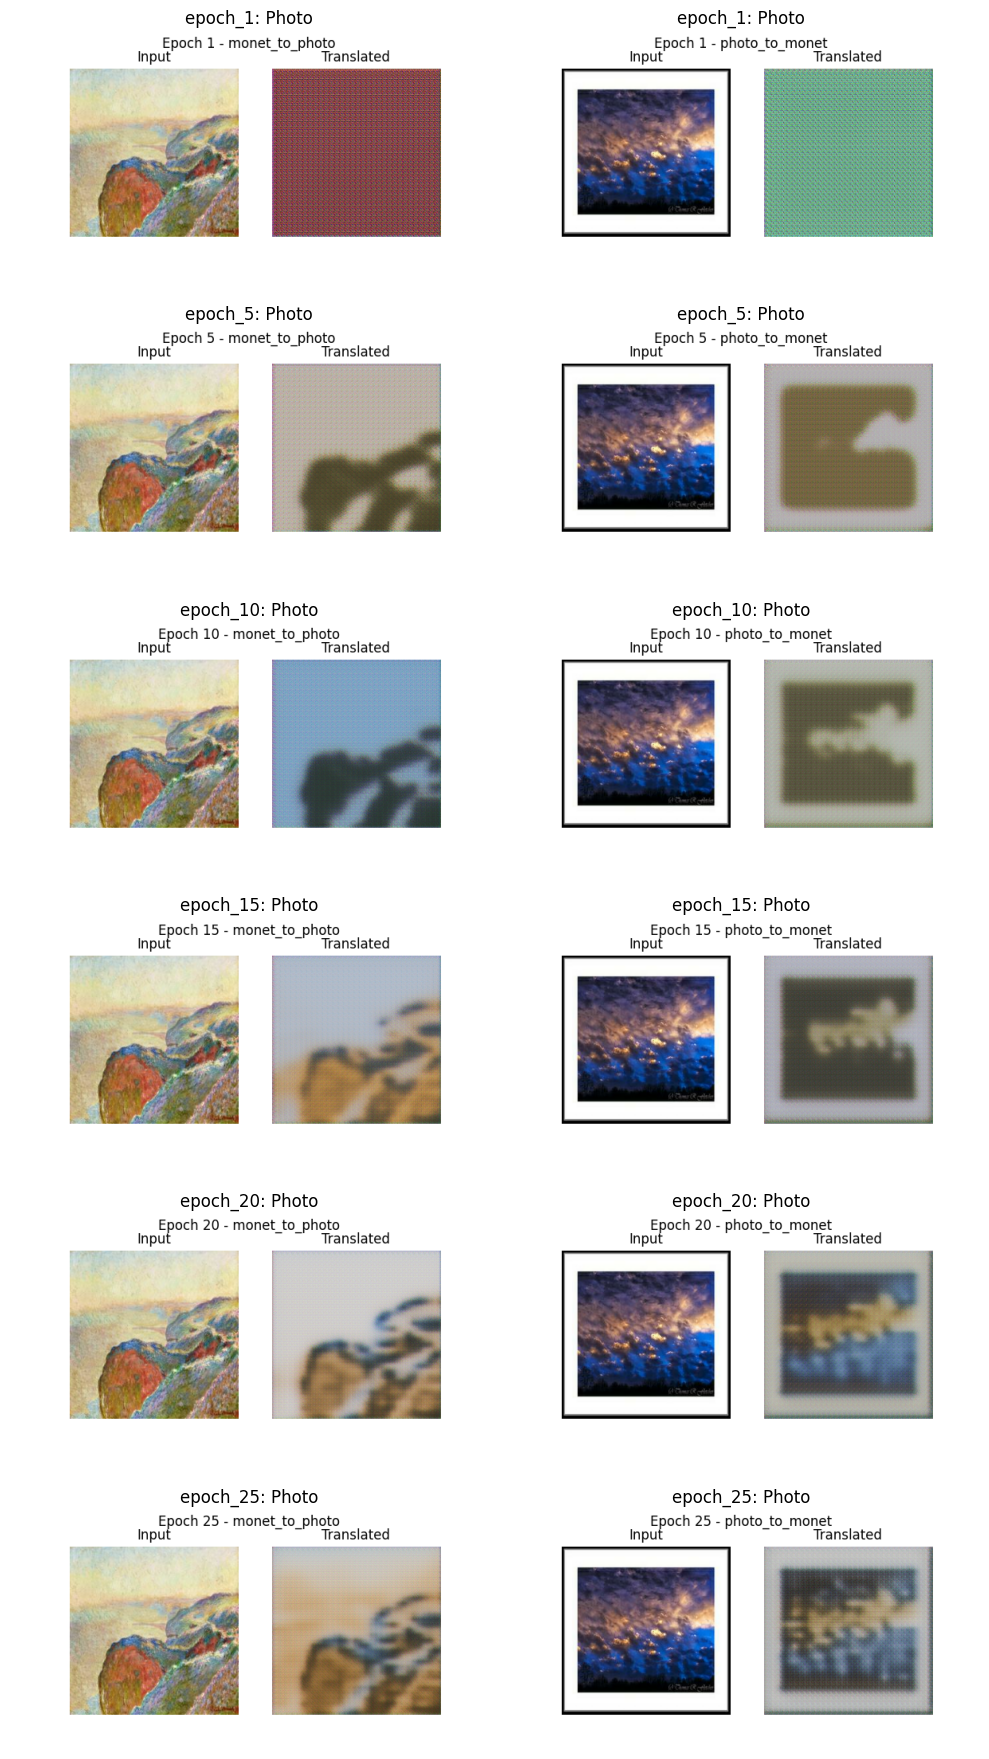

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

image_dir = "generated-images"
files = sorted(os.listdir(image_dir))

epoch_dict = {}
for file in files:
    if file.endswith(".png"):
        prefix = "_".join(file.split("_")[:2])
        epoch_dict.setdefault(prefix, []).append(file)


num_epochs = len(epoch_dict)
plt.figure(figsize=(10, num_epochs * 3))

for idx, (epoch, pair) in enumerate(sorted(epoch_dict.items(), key=lambda x: int(x[0].split("_")[1]))):
    pair = sorted(pair)
    for j, fname in enumerate(pair):
        img = Image.open(os.path.join(image_dir, fname))
        plt.subplot(num_epochs, 2, idx * 2 + j + 1)
        plt.imshow(img)
        plt.title(f"{epoch}: {'Photo' if 'photo' in fname else 'Monet'}")
        plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
"""
This block generates Monet-style images from the photo_jpg test set and streams each output 
directly into a single zip file.
"""

import os
import zipfile
from PIL import Image
from io import BytesIO
import numpy as np
import tensorflow as tf

photo_test_dir = '/kaggle/input/gan-getting-started/photo_jpg'
photo_filenames = sorted(os.listdir(photo_test_dir))
output_path = '/kaggle/working/images.zip'

with zipfile.ZipFile(output_path, 'w') as zipf:
    for i, fname in enumerate(photo_filenames):
        
        img_path = os.path.join(photo_test_dir, fname)
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [256, 256])
        img = (img / 127.5) - 1.0 
        img = tf.expand_dims(img, axis=0)

        monet_img = gen_F(img, training=False)[0]
        monet_img = (monet_img + 1.0) * 127.5 
        monet_img = tf.cast(monet_img, tf.uint8).numpy()

        im = Image.fromarray(monet_img)
        buffer = BytesIO()
        im.save(buffer, format='JPEG')
        buffer.seek(0)

        zipf.writestr(f"{i}.jpg", buffer.read())

print("images.zip created successfully")